# Missing values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
random.seed(430)

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

We laden hier de heart-disease dataset in, maar we verwijderen allerlei random waarden in de test dataset.
Wij gaan proberen om die waarden zo goed mogelijk in te vullen en een zo hoog mogelijke score te krijgen

In [2]:
df = pd.read_csv("dataset/heart.csv")
df = df.drop(columns=['oldpeak','trestbps', 'fbs','cp','thal','slope'])
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=80, random_state=99)

In [3]:
for index, row in X_test.iterrows():
    for x in range(4):
        col_to_clear = random.choice((X_test).columns)
        X_test[col_to_clear][index] = np.nan

In [4]:
print("Train dataset size:",X_train.shape[0])
print("Test dataset size", X_test.shape[0])

Train dataset size: 223
Test dataset size 80


Met deze functie kun je de accuracy van je invulling van missende waarden

In [5]:
clf = RandomForestClassifier(random_state=300, n_estimators=30, max_features=4, min_samples_split=10)
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=300,
                       verbose=0, warm_start=False)

In [6]:
def test_model(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_pred, y_test)

Je ziet hieronder dat er aardig wat waarden missen

In [7]:
X_test.head(10)

,age,sex,chol,restecg,thalach,exang,ca
137,NaN,NaN,NaN,0.0,140.0,NaN,0.0
262,53.0,NaN,NaN,NaN,95.0,1.0,2.0
43,53.0,NaN,NaN,0.0,143.0,0.0,NaN
90,NaN,NaN,255.0,NaN,NaN,0.0,2.0
32,NaN,NaN,219.0,NaN,188.0,0.0,0.0
61,54.0,NaN,NaN,1.0,156.0,NaN,NaN
72,29.0,NaN,NaN,NaN,202.0,0.0,NaN
10,54.0,NaN,NaN,1.0,NaN,0.0,0.0
240,70.0,NaN,269.0,1.0,112.0,NaN,NaN
111,NaN,1.0,126.0,NaN,NaN,NaN,1.0


Als we alle NaN waarden naar 0 zetten krijgen we een score van 0.66

In [8]:
# All nan values to 0
test_model(clf, X_train, X_test.replace(np.nan,0), y_train, y_test)

0.6375

In [9]:
X_train.columns

Index(['age', 'sex', 'chol', 'restecg', 'thalach', 'exang', 'ca'], dtype='object')

In [10]:
# All nan values to most common of that target
change_list = []
train_temp = X_train.join(y_train)
test_temp = X_test.join(y_test)
for index, row in test_temp.iterrows():
    row_set = False
    for col, value in row.iteritems():
        if np.isnan(value):
            try:
                if col in ['age','restecg','chol','thalach', 'ca']:
                    m = train_temp[train_temp.target == row.target][col].mean()
                else:
                    m = train_temp[train_temp.target == row.target][col].mode()
                X_test[col][index] = m
            except:
                X_test[col][index] = 0
                print("Error:",col)
            
            if row_set == False:
                change_list.append((col,index))
                row_set = True
X_test.head(10)

,age,sex,chol,restecg,thalach,exang,ca
137,53.198276,1.0,239.086207,0.000000,140.000000,0.0,0.000000
262,53.000000,1.0,252.719626,0.439252,95.000000,1.0,2.000000
43,53.000000,1.0,239.086207,0.000000,143.000000,0.0,0.327586
90,53.198276,1.0,255.000000,0.594828,157.491379,0.0,2.000000
32,53.198276,1.0,219.000000,0.594828,188.000000,0.0,0.000000
61,54.000000,1.0,239.086207,1.000000,156.000000,0.0,0.327586
72,29.000000,1.0,239.086207,0.594828,202.000000,0.0,0.327586
10,54.000000,1.0,239.086207,1.000000,157.491379,0.0,0.000000
240,70.000000,1.0,269.000000,1.000000,112.000000,1.0,1.149533
111,53.198276,1.0,126.000000,0.594828,157.491379,0.0,1.000000


In [11]:
# All nan values to 0
test_model(clf, X_train, X_test, y_train, y_test)

0.8625

# Proximity matrix

In [12]:
clf.fit(X_train,y_train)
leaves = clf.apply(X_train)
leaves.shape

(223, 30)

In [13]:
# leaves

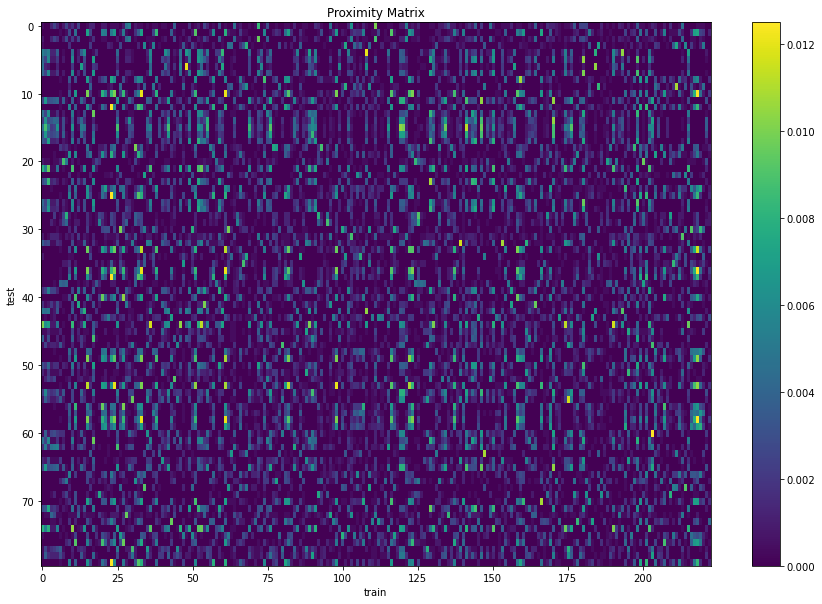

In [14]:
# proximity_matrix = np.zeros([X_train.count()[0]+1, X_train.count()[0]+1])
# print(proximity_matrix)
proximity_matrix = np.zeros([X_train.count()[0], len(change_list)])
n_trees = leaves.shape[1]

for item_index, item in enumerate(change_list):
    apl = clf.apply([X_test.loc[item[1]]])
    
    for tree_number in range(n_trees):
        for index, leaf in enumerate(leaves.T[tree_number]):
            if leaf == apl[0][tree_number]:
                proximity_matrix[index, item_index] += 1 / n_trees
                
plt.figure(figsize=[15,10])
plt.title("Proximity Matrix")
plt.xlabel('train')
plt.ylabel("test")
proximity_matrix = (proximity_matrix/X_test.count()[0]).T
plt.imshow(proximity_matrix, aspect='auto')
plt.colorbar()

In [15]:
proximity_matrix

array([[0.00041667, 0.        , 0.        , ..., 0.00041667, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00208333, 0.        ,
        0.00125   ],
       [0.00083333, 0.        , 0.        , ..., 0.00041667, 0.        ,
        0.        ],
       ...,
       [0.00041667, 0.0025    , 0.00083333, ..., 0.        , 0.00083333,
        0.        ],
       [0.00041667, 0.00375   , 0.00166667, ..., 0.        , 0.00166667,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00125   ]])

In [29]:
X_test_proximity = X_test.copy()

for item_index, item in enumerate(change_list):
    cur_val = X_test_proximity[item[0]][item[1]]
    
    
    
    if item[0] in ['sex','fbs','exang']: # Binary
        no_count, no_weight = 0, 1
        yes_count, yes_weight = 0, 1
        for i,x in enumerate(proximity_matrix[item_index]):
            val = X_train[item[0]].iloc[i]
            if val == 0:
                yes_count+=1
            elif val == 1:
                no_count+=1
                
        tot_count = no_count + yes_count
        yes = (no_count / tot_count) * (no_weight)
        no = (yes_count / tot_count) * (yes_weight)
        if yes > no:
            new_val = 1
        else:
            new_val = 0
    
    else:
        # Numeric
        total = cur_val
        for i,x in enumerate(proximity_matrix.T[item_index]):
            val = X_train[item[0]].iloc[i]
            total += (x * val) * (1-(1/X_test_proximity.shape[1]))

        new_val = total
    print(cur_val,'->',new_val)

    X_test_proximity[item[0]][item[1]] = new_val   

print(test_model(clf, X_train, X_test, y_train, y_test), '-->', 
      test_model(clf, X_train, X_test_proximity, y_train, y_test))

53.19827586206897 -> 58.649704433497526
1.0 -> 1
1.0 -> 1
53.19827586206897 -> 56.05327586206899
53.19827586206897 -> 56.58506157635469
1.0 -> 1
1.0 -> 1
1.0 -> 1
1.0 -> 1
53.19827586206897 -> 57.90149014778327
56.149532710280376 -> 63.173461281708946
239.08620689655172 -> 266.0004926108374
1.0 -> 1
239.08620689655172 -> 252.30834975369456
53.19827586206897 -> 57.82113300492612
53.19827586206897 -> 61.058633004926094
239.08620689655172 -> 254.2476354679803
53.19827586206897 -> 60.23684729064041
56.149532710280376 -> 57.1513184245661
56.149532710280376 -> 57.76881842456612
53.19827586206897 -> 59.94577586206896
1.0 -> 1
239.08620689655172 -> 245.4862068965517
157.49137931034483 -> 181.88495073891622
1.0 -> 1
56.149532710280376 -> 62.23203271028038
1.0 -> 1
53.19827586206897 -> 60.26184729064039
56.149532710280376 -> 59.73667556742327
1.0 -> 1
1.0 -> 1
1.0 -> 1
1.0 -> 1
1.0 -> 1
1.0 -> 1
56.149532710280376 -> 60.30596128170893
252.7196261682243 -> 281.01819759679563
56.149532710280376 ->